# Using HDF5 database

This tutorial shows how to store and retrieve models and their results from an HDF5 database ([see more](/user-guide/hdf5/)) integrated in pySWAP. We are going to:
- Load a test case model.
- Create an HDF5 database and save a model inside it.
- Retrieve a model from the HDF5 database.
- Alter the model and save its version back to the database.
- Compare the results.

We will also see how to do run a list of models in parallel.

In [1]:
from pyswap import db, run_parallel, testcase

# get the Model object and run it
ml = testcase.get("hupselbrook")
result = ml.run()
result.csv.head()

Warning from module Readswap : simulation with additonal Ksat value (Ksatexm)


,RAIN,IRRIG,INTERC,RUNOFF,EPOT,EACT,DRAINAGE,QBOTTOM,GWL,TPOT,TACT,DSTOR
DATETIME,,,,,,,,,,,,
2002-01-31,4.26,0.5,0.00000,0.0,0.75258,0.72884,2.67019,0.0,-67.00804,3.131000e-09,0.00000,1.36097
2002-02-28,12.29,0.0,0.00000,0.0,2.16968,2.03617,8.74135,0.0,-54.25989,2.828000e-09,0.00000,1.51248
2002-03-31,3.56,0.0,0.00000,0.0,4.11828,2.37341,4.49420,0.0,-77.49098,3.131000e-09,0.00000,-3.30761
2002-04-30,4.21,0.0,0.00000,0.0,6.63535,2.00082,0.83179,0.0,-71.39119,3.030000e-09,0.00000,1.37740
2002-05-31,5.29,0.0,0.02657,0.0,8.54549,2.50183,3.67905,0.0,-77.74911,5.113600e-01,0.51127,-1.42872


In [2]:
# create an interface object and save the model and the result
f = db.HDF5(filename="data.h5")
f.save_model(model=ml, result=result)

## Checking saved model

we can now check what is in the database. By calling `.list_models` property we will get a dictionary where keys are projects and values are lists of models inside the project.

In [3]:
f.list_models

{'psp test - hupselbrook': ['base']}

To retrieve a models from the database, use `.load()` method. It will 

## Loading models

Above you can see that the model was saved to the .h5 file. If the file already exists (for example one with your other projects), you will get a warning message and the program skips creation of additional elements in the database.

Now we are going to:
- Load a specific model (or all models from a project) from the HDF5 file.
- Create a copy of the loaded model and modify its parameters for another run.

In [4]:
db = f.load("psp test - hupselbrook", load_results=True)

As you can see below, the result of `.load()` is a dictionary where the key is the model version name, and the value is a tuple of `Model` and `Result` objects (or `Model` and None in case `load_results=False`).

In [5]:
db

{'base': (Model(version='base'), Result())}

## Creating model variants

we can create variants of the initial model by making copies of the initial model and updating one or more variables.

In [6]:
# For no reason, we will create 38 new versions, where in each version the drainage depth is increased by 2 cm
version = {f"drain_down_{i * 5}": {"zbotdr": -80.0 - i * 5} for i in range(1, 10)}

In [7]:
ml2 = db.get("base")[0]

Now we will make it a bit more complicated on purpose, to additionally show how to update nested objects. Above we defined the dictionary where the key is the new model version name and the values are new values for given attributes. As we cannot do a direct update of attributes of nested objects, we need to do it step by step:
- First we make new updated copies of the DraFile object from the initial model
- Then we make copies of Drainage objects from the initial model
- Last we create 3 copies of the model with updated lateraldrainage attribute.

We can use dictionary comprehension to get a dictionary of updated `DraFile` objects, which is nested in the lateraldrainage. The `.update()` method returns updated copies.

In [8]:
versions = {
    key: ml2.lateraldrainage.drafile.update(value) for key, value in version.items()
}

Now we create new models with the lateraldrainage attribute updated with the new `DraFile` objects. The list comprehension below returns a list of new `Model` objects updated with copies of `Drainage` objects:

In [9]:
mls = [
    ml2.update({
        "version": key,
        "lateraldrainage": ml2.lateraldrainage.update({"drafile": value}),
    })
    for key, value in versions.items()
]
print("There are", len(mls), "model versions")

There are 9 model versions


## Run in parallel and save in .h5

pyswap now has a simple way to parallellize running of the models. Instead of calling the .run() method, you need to use run_parallel() function, providing it with a list of model objects. A list of Result objects is returned.

In [10]:
results = run_parallel(mls, silence_warnings=True)

In [11]:
_ = [
    f.save_model(model=ml, result=result)
    for ml, result in zip(mls, results, strict=False)
]

In [12]:
f.list_models

{'psp test - hupselbrook': ['base',
  'drain_down_10',
  'drain_down_15',
  'drain_down_20',
  'drain_down_25',
  'drain_down_30',
  'drain_down_35',
  'drain_down_40',
  'drain_down_45',
  'drain_down_5']}

## Visualise the results

Now you can observe the results by plotting the main output pandas.DataFrame object, like you normally would.

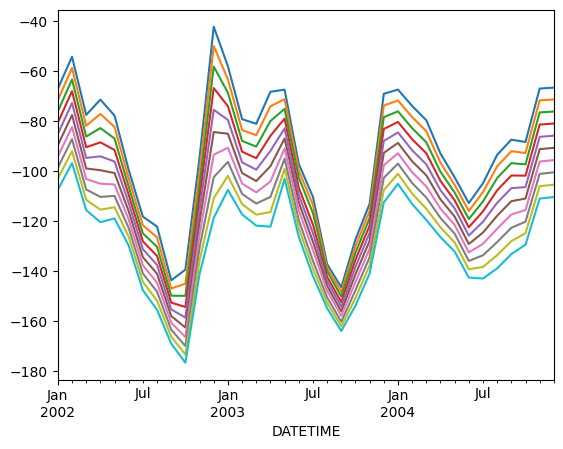

In [13]:
result.csv["GWL"].plot()
_ = [result.csv["GWL"].plot() for result in results]

## Deleting objects

You can use the `.delete()` method to delete the objects from the hdf5 database. You can delete either a specific model or the entire project. Use this method only for small deletions, as for now it does not perform repacking of the HDF5 file (the objects are deleted but the disk space is not freed). For large deletions, consider creating a new HDF5 file and saving only the models you want to keep.

In [14]:
f.list_models

{'psp test - hupselbrook': ['base',
  'drain_down_10',
  'drain_down_15',
  'drain_down_20',
  'drain_down_25',
  'drain_down_30',
  'drain_down_35',
  'drain_down_40',
  'drain_down_45',
  'drain_down_5']}

In [15]:
f.delete(project="psp test - hupselbrook", model="base")
f.list_models

{'psp test - hupselbrook': ['drain_down_10',
  'drain_down_15',
  'drain_down_20',
  'drain_down_25',
  'drain_down_30',
  'drain_down_35',
  'drain_down_40',
  'drain_down_45',
  'drain_down_5']}

You can also delete the entire project. This will remove the objects from the database, but the .h5 file will still have the same size. Therefore, for large deletions, it's better to replace the file entirely.

In [16]:
f.delete(project="psp test - hupselbrook")
f.list_models

{}